In [670]:
#Import relevant libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

#Loading of data 
df = pd.read_excel('../data/sds_datathon_gradsingapore.xlsx')
print(df.head())
print(df.columns)
#data loaded successfully

   Response ID        Time Started      Date Submitted        Status Language  \
0           19 2025-09-02 15:03:01 2025-09-02 15:03:40       Partial  English   
1           20 2025-09-02 15:15:32 2025-09-02 15:16:59  Disqualified  English   
2           21 2025-09-02 15:18:01 2025-09-02 15:19:30  Disqualified  English   
3           22 2025-09-03 15:25:18 2025-09-03 15:27:05      Complete  English   
4           23 2025-09-03 15:34:31 2025-09-03 15:34:31       Partial  English   

                            SessionID  \
0  1756796577_68b696a123dd27.81295289   
1  1756797328_68b699901c4cf6.89118890   
2  1756797478_68b69a26c5d785.44808899   
3  1756884314_68b7ed5a14f861.00788803   
4  1756884864_68b7ef80372683.27687311   

                                          User Agent  Tags      IP Address  \
0  Mozilla/5.0 (iPhone; CPU iPhone OS 18_6_2 like...   NaN  104.28.119.112   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...   NaN    57.140.24.26   
2  Mozilla/5.0 (Windows NT 10.0;

In [671]:
# 1. Clean all column headers to remove invisible characters (\xa0) and extra spaces
df.columns = df.columns.str.replace('\xa0', ' ', regex=True).str.strip()

# 2. Automatically find all columns related to the "Pick 3" question
# This searches for any column containing that specific question text
pick_3_cols = [col for col in df.columns if "What do you wish to learn more about regarding the organisation as an employer? (Pick 3)" in col]

# 3. Print them out just to verify we found all 7
print(f"Found {len(pick_3_cols)} columns for consolidation.")

# 4. Improved consolidation logic
def get_interests(row):
    # We use pd.notna and ensure the value isn't just an empty string
    interests = [str(row[col]).strip() for col in pick_3_cols 
                 if pd.notna(row[col]) and str(row[col]).strip() != '']
    return ", ".join(interests) if interests else "None Selected"

# 5. Apply and verify
df['Student_Interest_Profile'] = df.apply(get_interests, axis=1)
print(df)

#Ok correct, theres now a new column with them as strings

Found 7 columns for consolidation.
      Response ID        Time Started      Date Submitted        Status  \
0              19 2025-09-02 15:03:01 2025-09-02 15:03:40       Partial   
1              20 2025-09-02 15:15:32 2025-09-02 15:16:59  Disqualified   
2              21 2025-09-02 15:18:01 2025-09-02 15:19:30  Disqualified   
3              22 2025-09-03 15:25:18 2025-09-03 15:27:05      Complete   
4              23 2025-09-03 15:34:31 2025-09-03 15:34:31       Partial   
...           ...                 ...                 ...           ...   
2609         2628 2025-11-13 11:04:35 2025-11-13 11:31:13      Complete   
2610         2629 2025-11-13 11:16:03 2025-11-13 11:19:03      Complete   
2611         2630 2025-11-13 13:02:23 2025-11-13 13:02:56       Partial   
2612         2631 2025-11-13 14:28:12 2025-11-13 14:29:54  Disqualified   
2613         2632 2025-11-13 19:18:39 2025-11-13 19:20:50      Complete   

     Language                           SessionID  \
0     Engli

In [672]:
#Time taken so we can remove the redundant columns time start and time end
#first convert to datetime format
df['Time Started'] = pd.to_datetime(df['Time Started'], errors='coerce')
df['Date Submitted'] = pd.to_datetime(df['Date Submitted'], errors='coerce')

df['Time Taken'] = df['Date Submitted'] - df['Time Started']
df['Time Taken'] = df['Time Taken'].dt.total_seconds() / 60  # Convert to minutes

# Now we can drop the original time columns
df = df.drop(columns=['Time Started', 'Date Submitted'])

#handle edge cases 
df = df[df['Time Taken'] >= 0]  # Remove negative times if any
print(df[['Time Taken']])

#Okay looks correct

#Now i wna see the average of the time taken (for both complete and partial computed separately)
avg_time_complete = df[df['Status'] == 'Complete']['Time Taken'].mean()
avg_time_partial = df[df['Status'] == 'Partial']['Time Taken'].mean()

print(f"\nAvg Time Spent (Completed): {avg_time_complete:.2f} mins")
print(f"Avg Time Spent (Partial): {avg_time_partial:.2f} mins")

#completed average is at 242 minutes which means that on average, completed respondents spent 4 hours and 2 minutes on the survey.
#This means alot of them left the survey open for a long time 

      Time Taken
0       0.650000
1       1.450000
2       1.483333
3       1.783333
4       0.000000
...          ...
2609   26.633333
2610    3.000000
2611    0.550000
2612    1.700000
2613    2.183333

[2614 rows x 1 columns]

Avg Time Spent (Completed): 242.80 mins
Avg Time Spent (Partial): 27.44 mins


In [673]:
#Now we need to look at the median and outliers to see the truth
median_time_complete = df[df['Status'] == 'Complete']['Time Taken'].median()
median_time_partial = df[df['Status'] == 'Partial']['Time Taken'].median()

print(f"\nMedian Time Spent (Completed): {median_time_complete:.2f} mins")
print(f"Median Time Spent (Partial): {median_time_partial:.2f} mins")

#Identify outliers using IQR
Q1 = df['Time Taken'].quantile(0.25)
Q3 = df['Time Taken'].quantile(0.75)
IQR = Q3 - Q1

# Outliers are defined as points outside of 1.5 * IQR from the quartiles
outliers = df[(df['Time Taken'] < (Q1 - 1.5 * IQR)) | (df['Time Taken'] > (Q3 + 1.5 * IQR))]

print(f"\nOutliers Detected: {len(outliers)}")

#from the above, a median of 0 minutes for partial responses means most people likely open the link, see the first page and close immediately 
#we need to see what kind of questions they filled up and whats the definition of partial 

#median time for completed responses is not good either since the median is at 1.52 mins which means that they are skimming through, leading to many inaccuracies if survey not taken seriously 



Median Time Spent (Completed): 1.52 mins
Median Time Spent (Partial): 0.00 mins

Outliers Detected: 387


In [674]:
#scrutinise only the ones who partially completed the survey (are grouped under the status of partial)
partial_df = df[df['Status'] == 'Partial'].copy()

# 2. Find the last question each person answered
# We ignore the meta-columns (like Response ID, Time, etc.) and look at the actual questions
question_start_index = df.columns.get_loc('Which higher education institution do you or did you study at?')
question_cols = df.columns[question_start_index:]

def find_last_answered(row):
    # Iterate backwards through the question columns to find the first non-null value
    for col in reversed(question_cols):
        if pd.notna(row[col]) and str(row[col]).strip() != '':
            return col
    return "Never Started Questions"

partial_df['Dropoff_Question'] = partial_df.apply(find_last_answered, axis=1)

# 3. Calculate the Frequency of these drop-off points
dropoff_stats = partial_df['Dropoff_Question'].value_counts()

print("--- SURVEY FRICTION REPORT ---")
print(f"Total Partial Responses: {len(partial_df)}")
print("\nTop 5 Questions where people quit:")
print(dropoff_stats.head(5))


#need to define which questions are only survey questions
survey_questions = [
    'Which higher education institution do you or did you study at?',
    'What is your current year of study as of 2025?',
    'What will be your highest qualification when you graduate?',
    'Which of the following best describes the main subject that you are studying?',
    'Please indicate your nationality.',
    'What is your gender?',
    'Which of these statements best describes your current perception of the organisation as an employer?',
    'On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?'
]

def find_actual_dropoff(row):
    for col in reversed(survey_questions):
        if pd.notna(row[col]) and str(row[col]).strip() != '':
            return col
    return "Dropped before first question"

partial_df['Actual_Dropoff'] = partial_df.apply(find_actual_dropoff, axis=1)

print("REAL DROP-OFF POINTS:")
print(partial_df['Actual_Dropoff'].value_counts())

# Use Median for time to ignore the 4-hour outliers
print(f"\nMedian Time (Complete): {df[df['Status'] == 'Complete']['Time Taken'].median():.2f} mins")

--- SURVEY FRICTION REPORT ---
Total Partial Responses: 301

Top 5 Questions where people quit:
Dropoff_Question
Time Taken    301
Name: count, dtype: int64
REAL DROP-OFF POINTS:
Actual_Dropoff
Dropped before first question                                                                           237
What is your gender?                                                                                     62
Which higher education institution do you or did you study at?                                            1
Which of these statements best describes your current perception of the organisation as an employer?      1
Name: count, dtype: int64

Median Time (Complete): 1.52 mins


['Year 4' 'Year 3' nan 'Year 2' 'Others' 'Year 1']


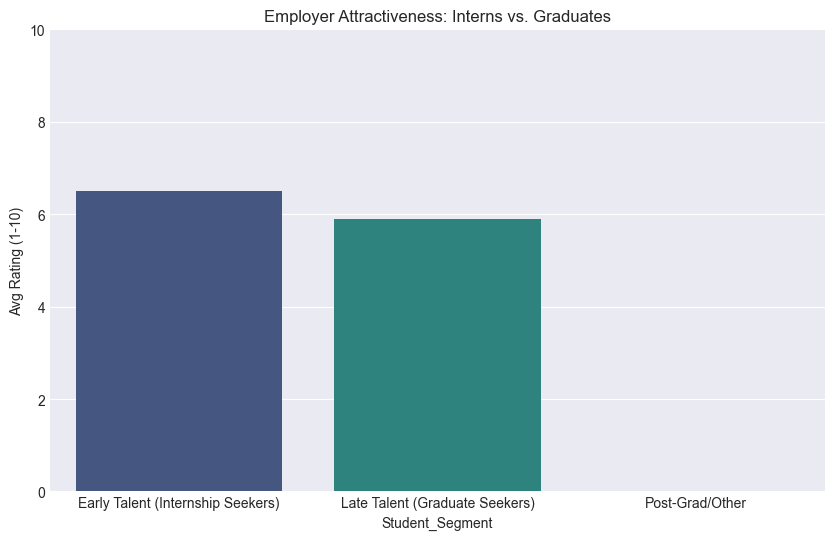

Attractiveness Scores by Segment:
Student_Segment
Early Talent (Internship Seekers)    6.492887
Late Talent (Graduate Seekers)       5.891271
Post-Grad/Other                           NaN
Name: rating_col, dtype: float64


In [675]:
#identify the demographics of surveyors 

#First we start by identifying if they are undergraduated or not
print(df['What is your current year of study as of 2025?'].unique())

#Theres year 1-4 and others and na 
#others probably means they might have graduated already 

# 1. Group the years into 'Early' (Y1/Y2) and 'Late' (Y3/Y4/Masters)
def categorize_year(year):
    year = str(year).lower()
    if '1' in year or '2' in year or 'freshman' in year or 'sophomore' in year:
        return 'Early Talent (Internship Seekers)'
    elif '3' in year or '4' in year or 'penultimate' in year or 'final' in year:
        return 'Late Talent (Graduate Seekers)'
    else:
        return 'Post-Grad/Other'

df['Student_Segment'] = df['What is your current year of study as of 2025?'].apply(categorize_year)

df['rating_col'] = df['On a scale from 1 to 10 (1 – Low, 10 – High), how would you rate the attractiveness of the organisation as an employer?']
# 2. Calculate average attractiveness per segment
segment_analysis = df.groupby('Student_Segment')['rating_col'].mean().sort_values(ascending=False)

# 3. Visualize the Gap
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_analysis.index, y=segment_analysis.values, palette='viridis')
plt.title('Employer Attractiveness: Interns vs. Graduates')
plt.ylabel('Avg Rating (1-10)')
plt.ylim(0, 10)
plt.show()

print("Attractiveness Scores by Segment:")
print(segment_analysis)

In [676]:
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Clean column names (remove spaces, special characters)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '').str.replace('/', '_')
print("Data loaded. Shape:", df.shape)

# 1. PRELIMINARY DATA CLEANING
print("\n=== 1. DATA CLEANING ===")

# Convert numeric columns
numeric_cols = ['response_id', 'postal', 
                'on_a_scale_from_1_to_10_1_low_10_high_how_would_you_rate_the_attractiveness_of_the_organisation_as_an_employer']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a cleaned version for analysis (complete responses only)
df_complete = df[df['status'] == 'Complete'].copy()
print(df.columns)
print(f"Complete responses: {len(df_complete)} out of {len(df)}")

df_partial = df[df['status'] == 'Partial'].copy()
print(f"Partial responses: {len(df_partial)} out of {len(df)}")

Data loaded. Shape: (2614, 34)

=== 1. DATA CLEANING ===
Index(['response_id', 'status', 'language', 'sessionid', 'user_agent', 'tags',
       'ip_address', 'longitude', 'latitude', 'country', 'city',
       'state_region', 'postal',
       'which_higher_education_institution_do_you_or_did_you_study_at?',
       'what_is_your_current_year_of_study_as_of_2025?',
       'what_will_be_your_highest_qualification_when_you_graduate?',
       'which_of_the_following_best_describes_the_main_subject_that_you_are_studying?',
       'please_indicate_your_nationality', 'what_is_your_gender?',
       'which_of_these_statements_best_describes_your_current_perception_of_the_organisation_as_an_employer?',
       'types_of_roles_available:what_do_you_wish_to_learn_more_about_regarding_the_organisation_as_an_employer?_(pick_3)',
       'career_progression_and_development:what_do_you_wish_to_learn_more_about_regarding_the_organisation_as_an_employer?_(pick_3)',
       'compensation_and_benefits:what_do_y

In [677]:
# 2. DEMOGRAPHIC SEGMENTATION (Complete Responses Only)
print("\n=== 2. DEMOGRAPHIC SEGMENTATION ===")

# 2a. University Segmentation (Complete Responses Only)
university_col = 'which_higher_education_institution_do_you_or_did_you_study_at?'
if university_col in df_complete.columns:
    print("\nUniversity Distribution (Complete responses only):")
    uni_counts = df_complete[university_col].value_counts()
    print(uni_counts)


=== 2. DEMOGRAPHIC SEGMENTATION ===

University Distribution (Complete responses only):
which_higher_education_institution_do_you_or_did_you_study_at?
National University of Singapore (NUS)                  1199
Nanyang Technological University (NTU)                   424
Singapore Management University (SMU)                     51
Yale-NUS College                                          43
SIM Global Education                                      28
National Institute of Education (NIE)                     17
LASALLE College of the Arts (LASALLE)                     12
Singapore Institute of Technology (SIT)                   11
James Cook University Singapore (JCU)                     10
Others                                                     9
Nanyang Academy of Fine Arts (NAFA)                        8
PSB Academy                                                7
Curtin University Singapore                                5
Singapore University of Technology and Design (SUTD)   

In [678]:
# 2b. Year of Study Segmentation (Complete Responses Only)
year_col = 'what_is_your_current_year_of_study_as_of_2025?'
if year_col in df_complete.columns:
    print("\nYear of Study Distribution:")
    print(df_complete[year_col].value_counts().sort_index())
    
    # Create year groups
    def group_year(year_str):
        if pd.isna(year_str):
            return 'Unknown'
        year_str = str(year_str).lower()
        if 'year 1' in year_str or '1' in year_str:
            return 'Year 1'
        elif 'year 2' in year_str or '2' in year_str:
            return 'Year 2'
        elif 'year 3' in year_str or '3' in year_str:
            return 'Year 3'
        elif 'year 4' in year_str or '4' in year_str:
            return 'Year 4'
        else:
            return 'Other/Unknown'
    
    df_complete['year_group'] = df_complete[year_col].apply(group_year)


Year of Study Distribution:
what_is_your_current_year_of_study_as_of_2025?
Year 1    654
Year 2    541
Year 3    386
Year 4    267
Name: count, dtype: int64


In [679]:
# 2c. Nationality Segmentation (Complete Responses Only)
nationality_col = 'please_indicate_your_nationality'
if nationality_col in df_complete.columns:
    print("\nNationality Distribution:")
    print(df_complete[nationality_col].value_counts())
    
    # Simplify nationality groups
    def simplify_nationality(nat):
        if pd.isna(nat):
            return 'Unknown'
        nat = str(nat).lower()
        if 'singapore' in nat:
            return 'Singaporean/PR'
        elif 'non-singaporean' in nat and 'long-term' in nat:
            return 'Non-SG with residency'
        elif 'non-singaporean' in nat:
            return 'Non-SG no residency'
        else:
            return 'Other'
    
    df_complete['nationality_group'] = df_complete[nationality_col].apply(simplify_nationality)


Nationality Distribution:
please_indicate_your_nationality
Singaporean/Singapore PR    1848
Name: count, dtype: int64


In [680]:
# 2d. Gender Segmentation (Complete Responses Only)
gender_col = 'what_is_your_gender?'
if gender_col in df_complete.columns:
    print("\nGender Distribution:")
    print(df_complete[gender_col].value_counts())
    
    # Simplify gender groups
    def simplify_gender(gender):
        if pd.isna(gender):
            return 'Unknown'
        gender = str(gender).lower()
        if 'female' in gender:
            return 'Female'
        elif 'male' in gender:
            return 'Male'
        elif 'prefer not' in gender:
            return 'Prefer not to say'
        else:
            return 'Other'
    
    df_complete['gender_group'] = df_complete[gender_col].apply(simplify_gender)


Gender Distribution:
what_is_your_gender?
Female               1108
Male                  686
Prefer not to say      54
Name: count, dtype: int64


In [681]:
# 2e. Field of Study Segmentation (Complete Responses Only)
field_col = 'which_of_the_following_best_describes_the_main_subject_that_you_are_studying?'
if field_col in df_complete.columns:
    print("\nFields of Study:")
    print(df_complete[field_col].value_counts())
    # Group fields into broader categories
    def group_field(field):
        if pd.isna(field):
            return 'Unknown'
        field = str(field).lower()
        
        if 'business' in field or 'management' in field or 'accounting' in field or 'finance' in field or 'marketing' in field:
            return 'Business/Management'
        elif 'engineering' in field or 'electrical' in field or 'mechanical' in field or 'civil' in field or 'chemical' in field:
            return 'Engineering'
        elif 'economics' in field:
            return 'Economics'
        elif 'it' in field or 'technology' in field:
            return 'IT/Tech'
        elif 'psychology' in field or 'social' in field or 'science' in field:
            return 'Social Sciences'
        elif 'arts' in field or 'design' in field or 'creative' in field:
            return 'Arts/Design'
        elif 'medicine' in field or 'dentistry' in field:
            return 'Medicine/Health'
        elif 'natural' in field or 'physics' in field or 'chemistry' in field or 'biology' in field:
            return 'Natural Sciences'
        elif 'education' in field or 'teaching' in field:
            return 'Education'
        elif 'law' in field:
            return 'Law'
        else:
            return 'Other'
    
    df_complete['field_group'] = df_complete[field_col].apply(group_field)


Fields of Study:
which_of_the_following_best_describes_the_main_subject_that_you_are_studying?
Natural Science (Physics, Chemistry, Biology, Earth Sciences, etc.)                                500
Mathematical Science/Statistics                                                                    266
Business/Management (Accounting, Finance, Marketing, Management, etc.)                             236
Medicine, Dentistry and related subjects                                                           141
Engineering (Electrical/Electronics, Mechanical, Civil, Chemical, Industrial Engineering, etc.)    139
IT and Technology                                                                                  121
Economics                                                                                          118
Psychology                                                                                          67
Geography and Environmental Science                                             

In [682]:
# 3. BEHAVIORAL SEGMENTATION (Complete Responses Only)
print("\n=== 3. BEHAVIORAL SEGMENTATION ===")

# 3a. Employer Perception Segmentation
perception_col = 'which_of_these_statements_best_describes_your_current_perception_of_the_organisation_as_an_employer?'
if perception_col in df_complete.columns:
    print("\nEmployer Perception Distribution:")
    print(df_complete[perception_col].value_counts())
    
    # Group perceptions
    def group_perception(perception):
        if pd.isna(perception):
            return 'No response'
        perception = str(perception).lower()
        
        if 'familiar' in perception and 'potential' in perception:
            return 'Familiar & Positive'
        elif 'positive impression' in perception:
            return 'Positive but Uninformed'
        elif 'recognise' in perception and 'clear' in perception:
            return 'Recognize but Unclear'
        elif 'not familiar' in perception:
            return 'Unfamiliar/No Opinion'
        else:
            return 'Other'
    
    df_complete['perception_group'] = df_complete[perception_col].apply(group_perception)


=== 3. BEHAVIORAL SEGMENTATION ===

Employer Perception Distribution:
which_of_these_statements_best_describes_your_current_perception_of_the_organisation_as_an_employer?
I recognise the organisation by name, but don’t have a clear impression of them                             564
I have a general positive impression of the organisation, but don’t know much about what jobs they offer    555
I’m familiar with the organisation and would consider them as a potential employer                          374
I’m not familiar enough with the organisation to form a solid opinion                                       355
Name: count, dtype: int64


In [683]:
# 3b. Motivation Segmentation (Complete Responses Only)
motivation_col = 'which_of_these_factors_would_most_motivate_you_to_apply_for_a_position_at_the_organisation?'
if motivation_col in df_complete.columns:
    print("\nMotivation Factors Distribution:")
    print(df_complete[motivation_col].value_counts())
    
    # Group motivations
    def group_motivation(motivation):
        if pd.isna(motivation):
            return 'No response'
        motivation = str(motivation).lower()
        
        if 'meaningful' in motivation:
            return 'Meaningful Work Impact'
        elif 'career growth' in motivation:
            return 'Career Growth Opportunities'
        elif 'work-life' in motivation:
            return 'Work-Life Balance'
        elif 'compensation' in motivation:
            return 'Compensation Package'
        elif 'job security' in motivation:
            return 'Job Security'
        elif 'learning' in motivation:
            return 'Learning & Development'
        else:
            return 'Other'
    
    df_complete['motivation_group'] = df_complete[motivation_col].apply(group_motivation)


Motivation Factors Distribution:
which_of_these_factors_would_most_motivate_you_to_apply_for_a_position_at_the_organisation?
Meaningful work impact         643
Career growth opportunities    400
Work-life balance              354
Job security                   253
Learning and development       102
Compensation package            89
Other - Write In (Required)      7
Name: count, dtype: int64


In [684]:
# 3c. Attractiveness Score Analysis (Complete Responses Only)
score_col = 'on_a_scale_from_1_to_10_(1_–_low,_10_–_high),_how_would_you_rate_the_attractiveness_of_the_organisation_as_an_employer?'
if score_col in df_complete.columns:
    print(f"\nAttractiveness Score Statistics:")
    print(f"Mean: {df_complete[score_col].mean():.2f}")
    print(f"Median: {df_complete[score_col].median():.2f}")
    print(f"Std Dev: {df_complete[score_col].std():.2f}")
    
    # Create score groups
    def group_score(score):
        if pd.isna(score):
            return 'No score'
        score = float(score)
        if score >= 8:
            return 'High (8-10)'
        elif score >= 5:
            return 'Medium (5-7)'
        else:
            return 'Low (1-4)'
    
    df_complete['score_group'] = df_complete[score_col].apply(group_score)


Attractiveness Score Statistics:
Mean: 6.28
Median: 6.00
Std Dev: 2.07


In [685]:
# 4. COMBINED SEGMENTATION ANALYSIS (Complete Responses Only)
print("\n=== 4. COMBINED SEGMENT ANALYSIS ===")

# Define meaningful segments
def define_segment(row):
    # Check if we have required data
    if pd.isna(row.get('field_group')) or pd.isna(row.get('perception_group')) or pd.isna(row.get('score_group')):
        return 'Insufficient Data'
    
    # Segment 1: Career-Driven Business Students
    if (row['field_group'] == 'Business/Management' and 
        row['perception_group'] in ['Familiar & Positive', 'Positive but Uninformed'] and
        row['score_group'] == 'High (8-10)'):
        return 'Career-Driven Business Students'
    
    # Segment 2: Engineering Pragmatists
    elif (row['field_group'] == 'Engineering' and 
          row['score_group'] in ['Medium (5-7)', 'High (8-10)'] and
          row.get('motivation_group') == 'Meaningful Work Impact'):
        return 'Engineering Pragmatists'
    
    # Segment 3: Culture-Seeking Arts/Social Science
    elif (row['field_group'] in ['Arts/Design', 'Social Sciences'] and 
          row['student_interest_profile'] == 'Culture-Focused' and
          row.get('motivation_group') == 'Work-Life Balance'):
        return 'Culture-Seeking Arts/Social Science'
    
    # Segment 4: High Potential but Uninformed
    elif (row['perception_group'] in ['Recognize but Unclear', 'Positive but Uninformed'] and 
          row['score_group'] in ['Medium (5-7)', 'High (8-10)']):
        return 'High Potential but Uninformed'
    
    # Segment 5: Disengaged/Non-Target
    elif (row['score_group'] == 'Low (1-4)' or 
          row['perception_group'] == 'Unfamiliar/No Opinion' or
          row.get('nationality_group', '') == 'Non-SG no residency'):
        return 'Disengaged/Non-Target'
    
    else:
        return 'Other Segment'

df_complete['segment'] = df_complete.apply(define_segment, axis=1)


=== 4. COMBINED SEGMENT ANALYSIS ===


In [686]:
# 2. DEMOGRAPHIC SEGMENTATION (Partial Responses Only)
print("\n=== 2. DEMOGRAPHIC SEGMENTATION ===")

# 2a. University Segmentation (Partial Responses Only)
university_col = 'which_higher_education_institution_do_you_or_did_you_study_at?'
if university_col in df_partial.columns:
    print("\nUniversity Distribution (Partial responses only):")
    uni_counts = df_partial[university_col].value_counts()
    print(uni_counts)


=== 2. DEMOGRAPHIC SEGMENTATION ===

University Distribution (Partial responses only):
which_higher_education_institution_do_you_or_did_you_study_at?
National University of Singapore (NUS)                  38
Nanyang Technological University (NTU)                  19
Yale-NUS College                                         2
Singapore Management University (SMU)                    1
SIM Global Education                                     1
Singapore Institute of Technology (SIT)                  1
Singapore University of Technology and Design (SUTD)     1
Curtin University Singapore                              1
Name: count, dtype: int64


In [687]:
# 2b. Year of Study Segmentation (Partial Responses Only)
year_col = 'what_is_your_current_year_of_study_as_of_2025?'
if year_col in df_partial.columns:
    print("\nYear of Study Distribution:")
    print(df_partial[year_col].value_counts().sort_index())
    
    # Create year groups
    def group_year(year_str):
        if pd.isna(year_str):
            return 'Unknown'
        year_str = str(year_str).lower()
        if 'year 1' in year_str or '1' in year_str:
            return 'Year 1'
        elif 'year 2' in year_str or '2' in year_str:
            return 'Year 2'
        elif 'year 3' in year_str or '3' in year_str:
            return 'Year 3'
        elif 'year 4' in year_str or '4' in year_str:
            return 'Year 4'
        else:
            return 'Other/Unknown'
    
    df_partial['year_group'] = df_partial[year_col].apply(group_year)


Year of Study Distribution:
what_is_your_current_year_of_study_as_of_2025?
Year 1    26
Year 2    17
Year 3    16
Year 4     4
Name: count, dtype: int64


In [688]:
# 2c. Nationality Segmentation (Partial Responses Only)
nationality_col = 'please_indicate_your_nationality'
if nationality_col in df_partial.columns:
    print("\nNationality Distribution:")
    print(df_partial[nationality_col].value_counts())
    
    # Simplify nationality groups
    def simplify_nationality(nat):
        if pd.isna(nat):
            return 'Unknown'
        nat = str(nat).lower()
        if 'singapore' in nat:
            return 'Singaporean/PR'
        elif 'non-singaporean' in nat and 'long-term' in nat:
            return 'Non-SG with residency'
        elif 'non-singaporean' in nat:
            return 'Non-SG no residency'
        else:
            return 'Other'

    df_partial['nationality_group'] = df_partial[nationality_col].apply(simplify_nationality)


Nationality Distribution:
please_indicate_your_nationality
Singaporean/Singapore PR                          62
Non-Singaporean, no long-term residence status     1
Name: count, dtype: int64


In [689]:
# 2d. Gender Segmentation (Partial Responses Only)
gender_col = 'what_is_your_gender?'
if gender_col in df_partial.columns:
    print("\nGender Distribution:")
    print(df_partial[gender_col].value_counts())
    
    # Simplify gender groups
    def simplify_gender(gender):
        if pd.isna(gender):
            return 'Unknown'
        gender = str(gender).lower()
        if 'female' in gender:
            return 'Female'
        elif 'male' in gender:
            return 'Male'
        elif 'prefer not' in gender:
            return 'Prefer not to say'
        else:
            return 'Other'

    df_partial['gender_group'] = df_partial[gender_col].apply(simplify_gender)


Gender Distribution:
what_is_your_gender?
Female               34
Male                 28
Prefer not to say     1
Name: count, dtype: int64


In [690]:
# 2e. Field of Study Segmentation (Partial Responses Only)
field_col = 'which_of_the_following_best_describes_the_main_subject_that_you_are_studying?'
if field_col in df_partial.columns:
    print("\nFields of Study:")
    print(df_partial[field_col].value_counts())
    # Group fields into broader categories
    def group_field(field):
        if pd.isna(field):
            return 'Unknown'
        field = str(field).lower()
        
        if 'business' in field or 'management' in field or 'accounting' in field or 'finance' in field or 'marketing' in field:
            return 'Business/Management'
        elif 'engineering' in field or 'electrical' in field or 'mechanical' in field or 'civil' in field or 'chemical' in field:
            return 'Engineering'
        elif 'economics' in field:
            return 'Economics'
        elif 'it' in field or 'technology' in field:
            return 'IT/Tech'
        elif 'psychology' in field or 'social' in field or 'science' in field:
            return 'Social Sciences'
        elif 'arts' in field or 'design' in field or 'creative' in field:
            return 'Arts/Design'
        elif 'medicine' in field or 'dentistry' in field:
            return 'Medicine/Health'
        elif 'natural' in field or 'physics' in field or 'chemistry' in field or 'biology' in field:
            return 'Natural Sciences'
        elif 'education' in field or 'teaching' in field:
            return 'Education'
        elif 'law' in field:
            return 'Law'
        else:
            return 'Other'

    df_partial['field_group'] = df_partial[field_col].apply(group_field)


Fields of Study:
which_of_the_following_best_describes_the_main_subject_that_you_are_studying?
Business/Management (Accounting, Finance, Marketing, Management, etc.)                             14
Engineering (Electrical/Electronics, Mechanical, Civil, Chemical, Industrial Engineering, etc.)    11
Natural Science (Physics, Chemistry, Biology, Earth Sciences, etc.)                                 8
Economics                                                                                           7
Mathematical Science/Statistics                                                                     7
IT and Technology                                                                                   6
Medicine, Dentistry and related subjects                                                            5
Agriculture, Veterinary Science and related subjects                                                2
Psychology                                                                              

In [691]:
# 3. BEHAVIORAL SEGMENTATION (Partial Responses Only)
print("\n=== 3. BEHAVIORAL SEGMENTATION ===")

# 3a. Employer Perception Segmentation
perception_col = 'which_of_these_statements_best_describes_your_current_perception_of_the_organisation_as_an_employer?'
if perception_col in df_partial.columns:
    print("\nEmployer Perception Distribution:")
    print(df_partial[perception_col].value_counts())
    
    # Group perceptions
    def group_perception(perception):
        if pd.isna(perception):
            return 'No response'
        perception = str(perception).lower()
        
        if 'familiar' in perception and 'potential' in perception:
            return 'Familiar & Positive'
        elif 'positive impression' in perception:
            return 'Positive but Uninformed'
        elif 'recognise' in perception and 'clear' in perception:
            return 'Recognize but Unclear'
        elif 'not familiar' in perception:
            return 'Unfamiliar/No Opinion'
        else:
            return 'Other'
    
    df_partial['perception_group'] = df_partial[perception_col].apply(group_perception)


=== 3. BEHAVIORAL SEGMENTATION ===

Employer Perception Distribution:
which_of_these_statements_best_describes_your_current_perception_of_the_organisation_as_an_employer?
I’m not familiar enough with the organisation to form a solid opinion    1
Name: count, dtype: int64


In [692]:
# 3b. Motivation Segmentation (Partial Responses Only)
motivation_col = 'which_of_these_factors_would_most_motivate_you_to_apply_for_a_position_at_the_organisation?'
if motivation_col in df_partial.columns:
    print("\nMotivation Factors Distribution:")
    print(df_partial[motivation_col].value_counts())
    
    # Group motivations
    def group_motivation(motivation):
        if pd.isna(motivation):
            return 'No response'
        motivation = str(motivation).lower()
        
        if 'meaningful' in motivation:
            return 'Meaningful Work Impact'
        elif 'career growth' in motivation:
            return 'Career Growth Opportunities'
        elif 'work-life' in motivation:
            return 'Work-Life Balance'
        elif 'compensation' in motivation:
            return 'Compensation Package'
        elif 'job security' in motivation:
            return 'Job Security'
        elif 'learning' in motivation:
            return 'Learning & Development'
        else:
            return 'Other'
    
    df_partial['motivation_group'] = df_partial[motivation_col].apply(group_motivation)


Motivation Factors Distribution:
Series([], Name: count, dtype: int64)


In [693]:
# 3c. Attractiveness Score Analysis (Partial Responses Only)
score_col = 'on_a_scale_from_1_to_10_(1_–_low,_10_–_high),_how_would_you_rate_the_attractiveness_of_the_organisation_as_an_employer?'
if score_col in df_partial.columns:
    print(f"\nAttractiveness Score Statistics:")
    print(f"Mean: {df_partial[score_col].mean():.2f}")
    print(f"Median: {df_partial[score_col].median():.2f}")
    print(f"Std Dev: {df_partial[score_col].std():.2f}")

    # Create score groups
    def group_score(score):
        if pd.isna(score):
            return 'No score'
        score = float(score)
        if score >= 8:
            return 'High (8-10)'
        elif score >= 5:
            return 'Medium (5-7)'
        else:
            return 'Low (1-4)'
    
    df_partial['score_group'] = df_partial[score_col].apply(group_score)


Attractiveness Score Statistics:
Mean: nan
Median: nan
Std Dev: nan
